# Assignment 2 MSDS 422
Decision Trees, Random Forests, and Gradient Boosting


The point of this assignment is to explore the usage of Decision Trees, Random Forests, and Gradient Boosting to predict whether someone will default on a loan, and if so by how much. We'll be using the data sets that we cleaned up in Assignment 1

#### Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt


# all of the different models for sklearn -- there's a few of them
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# pygraphviz -- for displaying the Decision Trees
import pygraphviz

### Import data

We'll start by importing everything as a dataframe

In [3]:
fn = './HMEQ_Loss_export.xlsx'

hmeq_pd = pd.read_excel(fn)

In [4]:
# drop the non-imputed versions of the various columns
# plus the column that was previously the index

# get rid of anything that has an imputed version
drop_list = [imp_item.split('impute_')[-1] for imp_item in hmeq_pd.columns if 'impute_' in imp_item]

# get rid of the categorical variables that contain strings
drop_list = drop_list + ['impute_REASON', 'impute_JOB'] # these exist as one-hot encoded fields now

# add Unnamed: 0
drop_list.append('Unnamed: 0')

# drop them in hmeq_pd
hmeq_pd.drop(columns=drop_list, inplace=True)

#### Create some of the functions we will be using repeatedly

Show the ROC curve and plot with the AUC in the legend

In [5]:
def ROC_AUC_show(model, data_train_in, data_train_target, data_test_in, data_test_target, plot=True):
    probs=model.predict_proba(data_train_in)[:,1]
    fpr_train, tpr_train, thresh = metrics.roc_curve(data_train_target, probs)
    auc_train = metrics.auc(fpr_train, tpr_train)
    probs=model.predict_proba(data_test_in)[:,1]
    fpr_test, tpr_test, thresh = metrics.roc_curve(data_test_target, probs)
    auc_test = metrics.auc(fpr_test, tpr_test)

    if plot:
        fig,ax = plt.subplots()
        ax.plot(fpr_train,tpr_train, label=f"AUC Train: {auc_train:0.2f}")
        ax.plot(fpr_test,tpr_test, label=f"AUC test: {auc_test:0.2f}")
        ax.legend()
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')

    return fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test


return a list of all variables used in a tree

In [6]:
# based on code from Prof Wedding, though I think this is a little more efficient
def getVars(tree_model, varNames):
    varUsed = [varNames[ind] for ind in tree_model.tree_.feature if ind != tree._tree.TREE_UNDEFINED]
    return list(set(varUsed))


## Break data into test and training sets

To start with, we'll create separate arrays for each target, since "TARGET_BAD_FLAG" and "TARGET_LOSS_AMT" will have some different stuff. For example, "TARGET_LOSS_AMT" will not want any predictions when the person *did not* default

We'll want to test on consistent sets between the different model types, so we can get the split up here then test below.

In [7]:
# bad_flag dataframe
flag_df = hmeq_pd.drop(columns='TARGET_LOSS_AMT')

# Loss amount - drop bad flag and rows with no loss
loss_df = hmeq_pd.loc[hmeq_pd['TARGET_BAD_FLAG'] == 1].drop(columns='TARGET_BAD_FLAG')



# split them up
[flag_train_df, flag_test_df] = train_test_split(flag_df, train_size=.9)
[loss_train_df, loss_test_df] = train_test_split(loss_df, train_size=.9)

# and make some numpy arrays since that's what scikit wants in this case
flag_train_target = flag_train_df[['TARGET_BAD_FLAG']].values
flag_train_in = flag_train_df.drop(columns='TARGET_BAD_FLAG').values
flag_test_target = flag_test_df[['TARGET_BAD_FLAG']].values
flag_test_in = flag_test_df.drop(columns='TARGET_BAD_FLAG').values
loss_train_target = loss_train_df[['TARGET_LOSS_AMT']].values
loss_train_in = loss_train_df.drop(columns='TARGET_LOSS_AMT').values
loss_test_target = loss_test_df[['TARGET_LOSS_AMT']].values
loss_test_in = loss_test_df.drop(columns='TARGET_LOSS_AMT').values

## Decision and regression trees

The "bad_flag" target will use a decision tree, whereas the "loss" would use a regression tree since it has continuous values


First, let's create the model for each

In [8]:
# for the "bad flag"
# flag_dt = tree.DecisionTreeClassifier() # initialize the classifier
# flag_dt = tree.DecisionTreeClassifier(max_depth=3) # initialize the classifier -- try limiting the depth
flag_dt = tree.DecisionTreeClassifier(max_depth=8) # 8 seems to be pretty good, without too much overfitting

# fit the model 
flag_dt = flag_dt.fit(flag_train_in, flag_train_target) # fit the model
flag_train_pred = flag_dt.predict(flag_train_in)
flag_test_pred = flag_dt.predict(flag_test_in)



# for the "loss_amt"
# loss_dt = tree.DecisionTreeRegressor()
# loss_dt = tree.DecisionTreeRegressor(max_depth=3)
loss_dt = tree.DecisionTreeRegressor(max_depth=8)
loss_dt = loss_dt.fit(loss_train_in, loss_train_target)
loss_train_pred = loss_dt.predict(loss_train_in)
loss_test_pred = loss_dt.predict(loss_test_in)


#### Looks at the quality of the predictions

We'll be using the "Accuracy" metric for the classifier, and R**2 for the regressor

In [9]:
sep_str = '--------------------------'

# print stuff out
print(sep_str)
print(f"Accuracy of Flag tree classifier:")
print(f"Training: {metrics.accuracy_score(flag_train_target, flag_train_pred)}")
print(f"Testing: {metrics.accuracy_score(flag_test_target, flag_test_pred)}")
print('\n')
print(sep_str)
print(f"MSE of Loss tree regressor:")
print(f"Training: {metrics.mean_squared_error(loss_train_target, loss_train_pred)}")
print(f"Testing: {metrics.mean_squared_error(loss_test_target, loss_test_pred)}")
print(f"R2 since those MSE values are hard to parse")
print(f"Training: {metrics.r2_score(loss_train_target, loss_train_pred)}")
print(f"Testing: {metrics.r2_score(loss_test_target, loss_test_pred)}")



--------------------------
Accuracy of Flag tree classifier:
Training: 0.9080909768829232
Testing: 0.889261744966443


--------------------------
MSE of Loss tree regressor:
Training: 3232654.2205900764
Testing: 41885616.41136013
R2 since those MSE values are hard to parse
Training: 0.9723368490687376
Testing: 0.6570088908409545


#### ROC curves
Looks at the true positive rate (TPR) vs the false positive rate (FPR)
The idea is that as the sensitivity of the model increases, the FPR will increase as well.

We will likely want to do this a few times, so let's go ahead and make a function that we'll reuse for the future models

This will only work for the classifiers, not the regressors, since it's comparing how accurate the classification is vs how often we make errors

--------------------------
Bad Flag ROC comparison


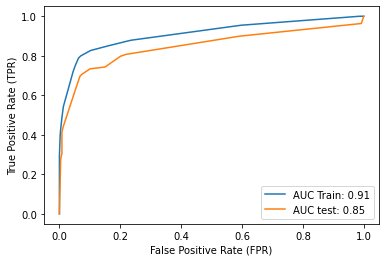

In [10]:
# for the "Bad Flag" classifier
print(sep_str)
print('Bad Flag ROC comparison')
ROC_resp = ROC_AUC_show(flag_dt, flag_train_in, flag_train_target, flag_test_in, flag_test_target)




#### Plotting using pygraphviz
Export to graphviz format, then plot it

In [11]:
flag_var_list = [col for col in flag_df.columns if 'TARGET' not in col]
loss_var_list = [col for col in loss_df.columns if 'TARGET' not in col]


flag_viz = tree.export_graphviz(flag_dt, feature_names=flag_var_list) # bad flag
loss_viz = tree.export_graphviz(loss_dt, feature_names=loss_var_list) # loss

tree.export_graphviz(flag_dt, "flag_dt.dot", feature_names=flag_var_list) # bad flag
tree.export_graphviz(loss_dt, "loss_dt.dot", feature_names=loss_var_list) # loss

flag_G = pygraphviz.AGraph(flag_viz)
loss_G = pygraphviz.AGraph(loss_viz)


flag_G.layout(prog='dot')
flag_G.draw("flag_dt.jpg")

loss_G.layout(prog='dot')
loss_G.draw("loss_dt.jpg")

C:\Users\17204\miniconda3\envs\MSDS\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.829439 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


![Decision Tree Example](flag_dt.jpg)

Let's take a look at what variables we used.

In [12]:
print(f"Variables used to build the 'Bad Flag' Decision Tree")
print(f"{getVars(flag_dt, flag_var_list)}")
print(sep_str)

print(f"Variables used to build the 'Loss Amt' Regression Tree")
print(f"{getVars(loss_dt, loss_var_list)}")

Variables used to build the 'Bad Flag' Decision Tree
['JOB__MISSING', 'impute_CLAGE', 'impute_LOAN', 'impute_VALUE', 'impute_CLNO', 'impute_NINQ', 'impute_YOJ', 'JOB__Office', 'JOB__Sales', 'impute_DELINQ', 'impute_DEROG', 'impute_MORTDUE', 'impute_DEBTINC']
--------------------------
Variables used to build the 'Loss Amt' Regression Tree
['impute_CLAGE', 'JOB__Mgr', 'impute_LOAN', 'impute_VALUE', 'JOB__ProfExe', 'impute_CLNO', 'impute_YOJ', 'IS_DEBTCON', 'impute_NINQ', 'JOB__Office', 'impute_DELINQ', 'impute_DEROG', 'impute_MORTDUE', 'impute_DEBTINC']


## Random Forests

Second verse, same as the first

This time we'll be working with Random Forests. Random Forests are basically a bunch of Decision Trees using different clusters of the data

In [13]:
# for the "bad flag"
# flag_rf = RandomForestClassifier() # initialize the classifier
flag_rf = RandomForestClassifier(max_depth=8, n_estimators=100) # initialize the classifier

# fit the model 
flag_rf = flag_rf.fit(flag_train_in, flag_train_target.reshape(len(flag_train_target),)) # fit the model
flag_train_pred_rf = flag_rf.predict(flag_train_in)
flag_test_pred_rf = flag_rf.predict(flag_test_in)



# for the "loss_amt"
loss_rf = RandomForestRegressor()
loss_rf = loss_rf.fit(loss_train_in, loss_train_target.reshape(len(loss_train_target),))
loss_train_pred_rf = loss_rf.predict(loss_train_in)
loss_test_pred_rf = loss_rf.predict(loss_test_in)


In [14]:
sep_str = '--------------------------'

# print stuff out
print(sep_str)
print(f"Accuracy of Flag random forest classifier:")
print(f"Training: {metrics.accuracy_score(flag_train_target, flag_train_pred_rf)}")
print(f"Testing: {metrics.accuracy_score(flag_test_target, flag_test_pred_rf)}")
print('\n')
print(sep_str)
print(f"MSE of Loss random forest regressor:")
print(f"Training: {metrics.mean_squared_error(loss_train_target, loss_train_pred_rf)}")
print(f"Testing: {metrics.mean_squared_error(loss_test_target, loss_test_pred_rf)}")
print(f"R2 of Loss random forest regressor:")
print(f"Training: {metrics.r2_score(loss_train_target, loss_train_pred_rf)}")
print(f"Testing: {metrics.r2_score(loss_test_target, loss_test_pred_rf)}")

--------------------------
Accuracy of Flag random forest classifier:
Training: 0.9164802386278896
Testing: 0.9261744966442953


--------------------------
MSE of Loss random forest regressor:
Training: 1233898.1454050464
Testing: 28748535.45855882
R2 of Loss random forest regressor:
Training: 0.9894410263823658
Testing: 0.7645852464772395


--------------------------
Bad Flag ROC comparison


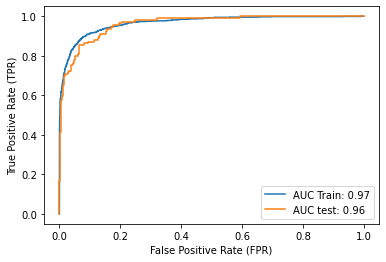

In [15]:
# for the "Bad Flag" classifier
print(sep_str)
print('Bad Flag ROC comparison')
ROC_resp = ROC_AUC_show(flag_rf, flag_train_in, flag_train_target, flag_test_in, flag_test_target)

Now for the list of variables for each. Since random forests are just a collection of trees, we just have to call it for each tree in the forest :)

In [16]:
# # get a list of variables that show up in each decision tree
# flag_forest_vars_all = [getVars(da_tree, flag_var_list) for da_tree in flag_rf.estimators_]
# flag_forest_vars = []
# for forest_var in flag_forest_vars_all:
    # flag_forest_vars = list(set(flag_forest_vars + forest_var))

# # print it
# print(f"Random forest used variables:")
# print(f"{flag_forest_vars}")
# print(sep_str)

# # get a list of variables that show up in each decision tree
# loss_forest_vars_all = [getVars(da_tree, loss_var_list) for da_tree in loss_rf.estimators_]
# loss_forest_vars = []
# for forest_var in loss_forest_vars_all:
    # loss_forest_vars = list(set(loss_forest_vars + forest_var))

# # print it
# print(f"Random forest used variables:")
# print(f"{loss_forest_vars}")

In [17]:
# classifier_rf
print(f"'Bad Flag' Random Forest important variables:")
print(f"{np.array(flag_var_list)[flag_rf.feature_importances_ > np.mean(flag_rf.feature_importances_)].tolist()}\n")

print(sep_str)
print("Loss Prediction important variables:")
print(f"{np.array(loss_var_list)[loss_rf.feature_importances_ > np.mean(loss_rf.feature_importances_)].tolist()}")


'Bad Flag' Random Forest important variables:
['impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_DEBTINC', 'impute_LOAN']

--------------------------
Loss Prediction important variables:
['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']


Looks like every variable is used at least once in both of the random forests

## Gradient Boosting

Now run through all of the same things with Gradient Boosting



In [18]:
# for the "bad flag"
flag_gb = GradientBoostingClassifier() # initialize the classifier

# fit the model 
flag_gb = flag_gb.fit(flag_train_in, flag_train_target.reshape(len(flag_train_target),)) # fit the model
flag_train_pred_gb = flag_gb.predict(flag_train_in)
flag_test_pred_gb = flag_gb.predict(flag_test_in)



# for the "loss_amt"
loss_gb = RandomForestRegressor()
# loss_gb = tree.DecisionTreeRegressor(max_depth=4)
loss_gb = loss_gb.fit(loss_train_in, loss_train_target.reshape(len(loss_train_target),))
loss_train_pred_gb = loss_gb.predict(loss_train_in)
loss_test_pred_gb = loss_gb.predict(loss_test_in)

In [19]:

sep_str = '--------------------------'

# print stuff out
print(sep_str)
print(f"Accuracy of Flag Gradient Boosting classifier:")
print(f"Training: {metrics.accuracy_score(flag_train_target, flag_train_pred_gb)}")
print(f"Testing: {metrics.accuracy_score(flag_test_target, flag_test_pred_gb)}")
print('\n')
print(sep_str)
print(f"MSE of Loss Gradient Boosting regressor:")
print(f"Training: {metrics.mean_squared_error(loss_train_target, loss_train_pred_gb)}")
print(f"Testing: {metrics.mean_squared_error(loss_test_target, loss_test_pred_gb)}")
print(f"R2 of Loss Gradient Boosting regressor:")
print(f"Training: {metrics.r2_score(loss_train_target, loss_train_pred_gb)}")
print(f"Testing: {metrics.r2_score(loss_test_target, loss_test_pred_gb)}")

--------------------------
Accuracy of Flag Gradient Boosting classifier:
Training: 0.9157345264727815
Testing: 0.912751677852349


--------------------------
MSE of Loss Gradient Boosting regressor:
Training: 1362870.6788024302
Testing: 27267396.093031093
R2 of Loss Gradient Boosting regressor:
Training: 0.9883373554005965
Testing: 0.7767139359254792


--------------------------
Bad Flag ROC comparison


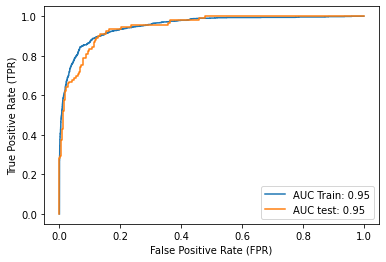

In [20]:
# for the "Bad Flag" classifier
print(sep_str)
print('Bad Flag ROC comparison')
ROC_resp = ROC_AUC_show(flag_gb, flag_train_in, flag_train_target, flag_test_in, flag_test_target)

In [21]:
# # get a list of variables that show up in each decision tree
# flag_boost_vars_all = [getVars(da_tree, flag_var_list) for da_tree in flag_gb.estimators_]
# flag_boost_vars = []
# for boost_var in flag_boost_vars_all:
    # flag_boost_vars = list(set(flag_boost_vars + boost_var))

# # print it
# print(f"Random boost used variables:")
# print(f"{flag_boost_vars}")
# print(sep_str)

# get a list of variables that show up in each decision tree
# loss_boost_vars_all = [getVars(da_tree[0], loss_var_list) for da_tree in loss_gb.estimators_]
# loss_boost_vars = []
# for boost_var in loss_boost_vars_all:
    # loss_boost_vars = list(set(loss_boost_vars + boost_var))
# 
# print it
# print(f"Random boost used variables:")
# print(f"{loss_boost_vars}")

In [24]:
# classifier_gb
print(f"'Bad Flag' Gradient Boosting important variables:")
print(f"{np.array(flag_var_list)[flag_gb.feature_importances_ > np.mean(flag_gb.feature_importances_)].tolist()}\n")

print(sep_str)
print("Loss Prediction important variables:")
print(f"{np.array(loss_var_list)[loss_gb.feature_importances_ > np.mean(loss_gb.feature_importances_)].tolist()}")

'Bad Flag' Gradient Boosting important variables:
['impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_DEBTINC']

--------------------------
Loss Prediction important variables:
['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']


### Export data

I'm exporting the two dataframes so that I don't have to reseparate and drop stuff in the coming weeks.

In [23]:
flag_fn = './HMEQ_Loss_export_flag.xlsx'
loss_fn = './HMEQ_Loss_export_loss.xlsx'

# # setup a context manager
# with pd.ExcelWriter(flag_fn, mode='w') as flag_file:
    # pass
flag_df.to_excel(flag_fn)
loss_df.to_excel(loss_fn)


